##  ewf-ext-03-04-01 - Temperature and Chlorophyll anomalies for coastal areas

### <a name="service">Service definition

In [77]:
service = dict([('title', 'ewf-ext-03-04-01 - Temperature and Chlorophyll anomalies for coastal areas'),
                ('abstract', 'ewf-ext-03-04-01 - Temperature and Chlorophyll anomalies for coastal areas'),
                ('id', 'ewf-ext-03-04-01')])

### Parameter Definition

In [78]:
yoi = dict([('id', 'yoi'),
            ('value', '2019'),
            ('title', 'year of interest'),
            ('abstract', 'year of interest')])

In [79]:
start_year = dict([('id', 'start_year'),
            ('value', '2018'),
            ('title', 'start year'),
            ('abstract', 'start year')])

In [80]:
end_year = dict([('id', 'end_year'),
            ('value', '2019'),
            ('title', 'end_year'),
            ('abstract', 'end_year')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the Sentinel-1 stack of products' identifiers

In [109]:
input_identifiers = ( '20180101000000-GOS-L3S_GHRSST-SSTsubskin-night_SST_HR_NRT-MED-v02.0-fv01.0.nc', '20190101000000-GOS-L3S_GHRSST-SSTsubskin-night_SST_HR_NRT-MED-v02.0-fv01.0.nc',
                      '20180102000000-GOS-L3S_GHRSST-SSTsubskin-night_SST_HR_NRT-MED-v02.0-fv01.0.nc', '20190102000000-GOS-L3S_GHRSST-SSTsubskin-night_SST_HR_NRT-MED-v02.0-fv01.0.nc',
                      '20180103000000-GOS-L3S_GHRSST-SSTsubskin-night_SST_HR_NRT-MED-v02.0-fv01.0.nc', '20190103000000-GOS-L3S_GHRSST-SSTsubskin-night_SST_HR_NRT-MED-v02.0-fv01.0.nc')


**Input references**

This is the Sentinel-1 stack catalogue references

In [82]:
#input_references = ( 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20151226T182813_20151226T182838_009217_00D48F_5D5F', 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20160424T182813_20160424T182838_010967_010769_AA98', 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20160518T182817_20160518T182842_011317_011291_936E', 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20160611T182819_20160611T182844_011667_011DC0_391B', 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20160705T182820_20160705T182845_012017_0128E1_D4EE', 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20160729T182822_20160729T182847_012367_013456_E8BF', 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20160822T182823_20160822T182848_012717_013FFE_90AF', 'https://catalog.terradue.com/sentinel1/search?uid=S1A_IW_GRDH_1SDV_20160915T182824_20160915T182849_013067_014B77_1FCD' ) 

**Data path**

This path defines where the data is staged-in. 

In [114]:
data_path = "/workspace/data/CMEMS/SST_MED_SST_L3S_NRT_OBSERVATIONS_010_012_a/data"

In [84]:
output_folder = "/workspace/Better_3rd_phase/Applications/EXT-03-04-01/ewf-ext-03-04-01/src/main/app-resources/notebook/libexec/Output"

In [85]:
temp_folder = '/workspace/Better_3rd_phase/Applications/EXT-03-04-01/ewf-ext-03-04-01/src/main/app-resources/notebook/libexec/Temp'

#### Import Modules

In [86]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import pdb

#### Auxiliary methods

In [87]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            

def crop_image(input_image, polygon_wkt, output_path, product_type=None):    
    
    dataset = None
    
    # creates directory if it doesnt exist yet
    crop_directory = os.path.dirname(output_path)
    if crop_directory is not '' and not os.path.exists(crop_directory):
        os.makedirs(crop_directory)
        
    
    if input_image.startswith('ftp://') or input_image.startswith('http'):
        try:
            dataset = gdal.Open('/vsigzip//vsicurl/%s' % input_image)
        except Exception as e:
            print(e)
    elif '.nc' in input_image:
        dataset = gdal.Open('NETCDF:' + input_image + ':' + product_type)
        
    else: # .tif
        dataset = gdal.Open(input_image)
        
    
    no_data_value = dataset.GetRasterBand(1).GetNoDataValue()
    geo_t = dataset.GetGeoTransform()
    polygon_ogr = ogr.CreateGeometryFromWkt(polygon_wkt)
    envelope = polygon_ogr.GetEnvelope()
    bounds = [envelope[0], envelope[2], envelope[1], envelope[3]]
    gdal.Warp(output_path, dataset, format="GTiff", outputBoundsSRS='EPSG:4326', outputBounds=bounds, srcNodata=no_data_value, dstNodata=no_data_value, xRes=geo_t[1], yRes=-geo_t[5], targetAlignedPixels=True)
    

    
def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    if filepath is None:
        print  "filepath"
    if output is None:
        print  "output"
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)



    
def calc_max_matrix(mat1, mat2, no_data_value=None):
    
    if no_data_value is not None:
        if not isinstance(mat1, int):
            mat1[(mat1 == no_data_value)] = 0
        if not isinstance(mat2, int):
            mat2[(mat2 == no_data_value)] = 0
    
    return np.where(mat1 > mat2, mat1, mat2)


def matrix_sum(mat1, mat2, no_data_value=None):
    if no_data_value is not None:
        if not isinstance(mat1, int):
            mat1[(mat1 == no_data_value)] = 0
        if not isinstance(mat2, int):
            mat2[(mat2 == no_data_value)] = 0
            
            
    msum = mat1 + mat2
    return msum
            

def calc_average(matrix_list, n_matrix, no_data_value=None):
    if not matrix_list:
        return 0
    result = matrix_list[0]
    for i in range(1, n_matrix):
        result = matrix_sum(result, matrix_list[i], no_data_value)
    
    return np.divide(result, (n_matrix*1.00))

def calc_standarddeviation(matrix_list, average_matrix, no_data_value=None):
    if not matrix_list:
        return 0
    result = np.zeros(average_matrix.shape)
    for matrix in matrix_list: 
        result = matrix_sum(np.square(matrix_sum(matrix, np.negative(average_matrix))), result)              
    return np.sqrt(np.divide(result, (len(matrix_list)*1.00)))

def get_matrix_list(image_list, product_type):
    projection = None
    geo_transform = None
    no_data = None
    mat_list = []
    for img in image_list:
        dataset = gdal.Open('NETCDF:' + img + ':' + product_type)
        projection = dataset.GetProjection()
        geo_transform = dataset.GetGeoTransform()
        no_data = dataset.GetRasterBand(1).GetNoDataValue()
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list, projection, geo_transform, no_data

def calculate_anomaly(averagesigma, doy):
    above = averagesigma > doy
    below = averagesigma < doy
    return above*1, below*1
    

def write_outputs(product_name, first_date, last_date, averages, standard_deviation, image_format, projection, geo_transform, no_data_value):
    filenames = []
    filenames.append(product_name + '_' + '_averages_' + first_date + '_' + last_date + '.tif')
    filenames.append(product_name + '_' + '_standarddeviation_' + first_date + '_' + last_date + '.tif')

    write_output_image(filenames[0], averages, image_format, gdal.GDT_Int16, None, projection, geo_transform, no_data_value)
    write_output_image(filenames[1], standard_deviation, image_format, gdal.GDT_Int16, None, projection, geo_transform, no_data_value)
    
    return filenames

def isleap(year):
    """Return True for leap years, False for non-leap years."""
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)


#### Workflow

In [88]:
yoi['value'], start_year['value'], end_year['value']

('2019', '2018', '2019')

In [148]:
from calendar import monthrange

yearofinterest = int(yoi['value'])
start_year_int = int(start_year['value'])
end_year_int = int(end_year['value'])
anomaly_year_index = yearofinterest - start_year_int

if isinstance(input_identifiers, str):
    input_identifiers = [input_identifiers]

#first_date = os.path.splitext(input_identifiers[0])[0].split('-')[0]
#last_date = os.path.splitext(input_identifiers[-1])[0].split('-')[0]

#input_identifiers.sort()
days = 0

for year in range(start_year_int, end_year_int):
    if isleap(year):
        days += 366
    else:
        days += 365

product_path_name = output_folder + '/' + 'CMEMS'
below = None
above = None
average = None
projection = None
geo_transform = None
no_data = None
for month in range(1,13):
    getout = False
    for day in range(1, monthrange(yearofinterest, month)[1]+1):
        file_list = []
        month_and_day = str(month).zfill(2)  + str(day).zfill(2)
        for year in range(start_year_int, end_year_int+1):
            date = str(year) + month_and_day + "000000"
            matching = [s for s in input_identifiers if date in s]
            if len(matching) == 1:
                file = matching[0]
                file_list.append(file)
            else:
                print "file not found on input_identifier => " + date
                getout = True
                break
        if getout == True:
            getout = False
            break #continue to try the next day, break next month
        first_date = file_list[0].split('-')[0]
        last_date = file_list[-1].split('-')[0]
        file_list[:] = [data_path + '/' + filename for filename in file_list]
        n_years = end_year_int - start_year_int + 1
        if n_years == len(file_list):
            mat_list, projection, geo_transform, no_data = get_matrix_list(file_list, "adjusted_sea_surface_temperature")
            average = calc_average(mat_list, len(file_list))
            standarddeviations = calc_standarddeviation(mat_list, average)
            averagesigma = matrix_sum(average, standarddeviations)
            above_mat, below_mat = calculate_anomaly(averagesigma, mat_list[anomaly_year_index])
            if (above is None) or (below is None):
                above = np.zeros(above_mat.shape)
                below = np.zeros(below_mat.shape)
            above += above_mat
            below += below_mat
            write_outputs(product_path_name, first_date, last_date, average, standarddeviations, 'GTiff', projection, geo_transform, no_data)
        else:
            print "error" + str(len(file_list))
#    if getout == True:
#        break


write_output_image(product_path_name + '_above' + '.tif', above, 'GTiff', gdal.GDT_Int16, None, projection, geo_transform, no_data)
write_output_image(product_path_name + '_below' + '.tif', below, 'GTiff', gdal.GDT_Int16, None, projection, geo_transform, no_data)


file not found on input_identifier => 20180104000000
file not found on input_identifier => 20180201000000
file not found on input_identifier => 20180301000000
file not found on input_identifier => 20180401000000
file not found on input_identifier => 20180501000000
file not found on input_identifier => 20180601000000
file not found on input_identifier => 20180701000000
file not found on input_identifier => 20180801000000
file not found on input_identifier => 20180901000000
file not found on input_identifier => 20181001000000
file not found on input_identifier => 20181101000000
file not found on input_identifier => 20181201000000


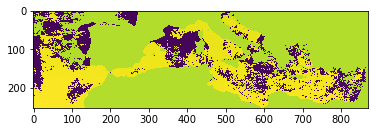

In [142]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(average)
plt.show()

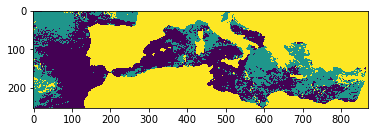

In [35]:
plt.imshow(standarddeviations)
plt.show()

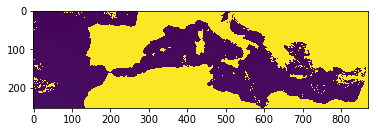

In [36]:
plt.imshow(sum_averages_standarddeviations)
plt.show()

In [21]:
product_path_name = output_folder + '/' + 'CMEMS'

filenames = write_outputs(product_path_name, first_date, last_date, averages, standarddeviations, 'GTiff', projection, geo_transform, no_data)

# TODO
#write_properties_file(interval_gpd, output_name)

In [22]:
# CHECK

import rasterio

from rasterio.plot import show


# Load data
#raster = output_folder + '/' + 'LST_SouthernAfrica_N3_maxvalues_'+first_date+'_'+last_date+'.tif'
raster = filenames[0]
data = rasterio.open(raster)

show(data)

#data = georasters.from_file(raster)

# Plot data
#data.plot()

#print(no_data)


ImportError: No module named rasterio